🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before). 

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning==1.5.4

In [2]:
# !pip install matplotlib seaborn

In [3]:
# !pip install albumentations

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import albumentations as A

from pprint import pprint
from torch.utils.data import DataLoader

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [2]:
from brightfield import BrightfieldDataset

In [3]:
root = "../../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# transform = transforms.Compose(
#     [transforms.Resize((256,256)),     
#      transforms.ToTensor(),
#      transforms.ConvertImageDtype(torch.float32),
#     ])

# transform = transforms.Compose(
#     [transforms.RandomCrop(size=(256,256)),
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.RandomRotation(90),
#     ])

transform = A.Compose([
    A.Flip(p=0.5),
    A.RandomRotate90(p=0.5),
#     A.GaussianBlur(p=0.5), #this is causing the image to became all ones
#     A.RandomBrightnessContrast(contrast_limit=0.2, p=0.5),
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True),
    ])

transform_val = A.Compose([
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True),
    ])

transform_test = A.Compose([
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True)])

In [5]:
split = pd.read_csv("../../baseline_images_stratified.csv")
# split.stencil.values[0]

In [6]:
image_filename = split.bf.values[0]
image_path = os.path.join(root, "images", image_filename[image_filename.rfind("/")+1:])
mask_filename = split.stencil.values[0]
mask_path = os.path.join(root, "complete_stencils", mask_filename[mask_filename.rfind("/")+1:])
image = np.array(Image.open(image_path), dtype=np.uint16)
print(image.shape)
image = np.moveaxis(image, -1, 0)
# image = np.expand_dims(image, -1)        
print(image.shape)
mask = np.array(Image.open(mask_path), dtype=np.uint16)
print(mask.shape)
# mask = np.expand_dims(mask, -1)    
print(mask.shape)
sample = dict(image=image, mask=mask)
new_sample = transform(**sample)


(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)


(1080, 1080)
(1080, 1080)


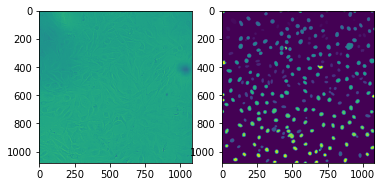

(256, 256)
(256, 256)


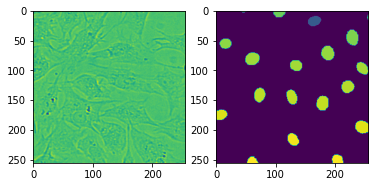

In [7]:
plt.subplot(1,2,1)
print(sample["image"].shape)
plt.imshow(sample["image"]) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
print(sample["mask"].shape)
plt.imshow(sample["mask"])  # for visualization we have to remove 3rd dimension of mask
plt.show()

plt.subplot(1,2,1)
print(new_sample["image"].shape)
plt.imshow(new_sample["image"]) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
print(new_sample["mask"].shape)
plt.imshow(new_sample["mask"])  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [9]:
from imgutils import separate_blobs, fix_shape, standardize

In [10]:
fix_shape(new_sample["mask"]).shape

(1, 256, 256, 1)

In [11]:
batch_mask = np.stack([np.expand_dims(new_sample["mask"],-1), np.expand_dims(new_sample["mask"],-1)])
batch_mask.shape

(2, 256, 256, 1)

In [12]:
new_batch_mask = separate_blobs(batch_mask)
new_batch_mask.shape


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


(2, 256, 256, 1)

0 146
(256, 256, 1)


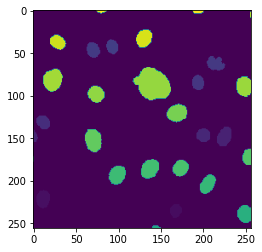

In [13]:
print(np.min(new_batch_mask[0]), np.max(new_batch_mask[0]))
print(new_batch_mask[0].shape)
plt.imshow(new_batch_mask[0])

In [8]:
BATCH_SIZE = 16

In [9]:
split_file = "../../baseline_images_stratified.csv"
train_dataset = BrightfieldDataset(root, "train", split_file=split_file, transform=transform)
valid_dataset = BrightfieldDataset(root, "val", split_file=split_file, transform=transform)
test_dataset = BrightfieldDataset(root, "test", split_file=split_file, transform=transform)

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

Train size: 2016
Valid size: 504
Test size: 504


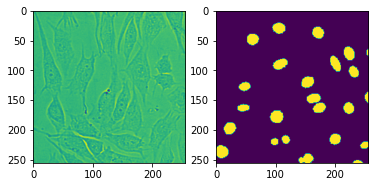

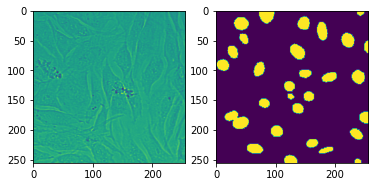

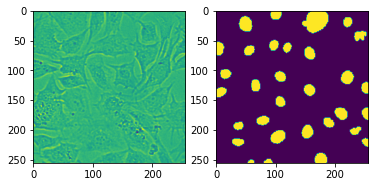

In [10]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [11]:
np.min(sample["image"]), np.max(sample["image"])

(3036.0, 11719.0)

## Model

In [11]:
# import timm
# timm.models.registry._model_has_pretrained
# smp.encoders.get_preprocessing_params("tu-vit_base_patch16_224")

In [12]:
smp.encoders.get_preprocessing_params("resnet34")

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [13]:
from functional import *
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params("resnet34")
        # mean and std calculated over all training images
        params["mean"] = [[[5388.582166338724]]]
        params["std"] = [[[530.4326381777722]]]
        self.register_buffer("std", torch.tensor(params["std"]))
        self.register_buffer("mean", torch.tensor(params["mean"]))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
#         image = standardize(image)
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [14]:
model = PetModel("UNet", "tu-swinnet26t_256", in_channels=1, out_classes=1)
# model = PetModel("UNet", "tu-botnet26t_256", in_channels=1, out_classes=1)
# model = PetModel("UNet", "resnet34", in_channels=1, out_classes=1)

/home/braian/anaconda3/envs/mt-proj/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No pretrained weights exist for this model. Using random initialization.


## Training

In [15]:
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpointer = ModelCheckpoint(
    dirpath='checkpoints/swinnet26t_256-aug/',
#     dirpath='checkpoints/resnet34-2/',
    filename='{epoch}-{val_loss:.2f}-{valid_dataset_iou:.2f}'
)
early_stopping = EarlyStopping('valid_dataset_iou', mode='max', patience=20, verbose=True)

trainer = pl.Trainer(
    gpus=1, 
    accelerator='auto',
    devices=device,
    max_epochs=800,
    callbacks=[TQDMProgressBar(refresh_rate=10), checkpointer, early_stopping],
    logger=CSVLogger(save_dir="logs-swinnet/"),
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 19.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.399    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved. New best score: 0.156


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.158


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.159


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.164


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.165


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.165


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.167


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.173


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.175


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.177


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.181


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.183


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.186


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.190


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.191


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.193


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.198


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.203


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.203


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.206


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.210


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.215


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.216


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.224


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.011 >= min_delta = 0.0. New best score: 0.235


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.247


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.251


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.253


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.260


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.261


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.268


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.270


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.274


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.281


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.282


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.283


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.288


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.293


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.298


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.298


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.299


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.302


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.303


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.304


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.306


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.308


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.313


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.314


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.319


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.319


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.322


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.323


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.325


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.328


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.328


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.330


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.331


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.332


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.335


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.337


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.342


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.344


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.345


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.346


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.349


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.353


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.353


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.355


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.357


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.365


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.365


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.367


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.367


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.374


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.378


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.384


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.391


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.394


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.396


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.399


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.402


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.406


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.011 >= min_delta = 0.0. New best score: 0.417


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.417


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.427


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.435


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.436


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.441


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.445


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.449


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.459


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.466


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.470


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.473


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.479


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.482


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.484


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.485


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.488


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.489


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.494


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.495


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.496


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.498


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.503


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.507


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.513


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.517


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.519


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.520


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.521


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.526


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.527


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.528


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.530


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.533


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.534


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.537


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.538


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.540


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.544


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.546


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.547


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.548


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.552


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.558


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.561


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.563


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.566


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.567


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.567


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.569


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.572


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.573


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.579


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.581


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.582


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.582


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.583


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.583


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.584


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.586


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.589


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.590


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.591


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.592


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.596


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.596


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.597


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.598


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.599


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.603


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.607


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.607


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.612


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.613


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.614


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.617


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.617


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.619


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.619


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.622


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.624


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.624


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.625


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.629


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.635


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.639


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.643


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.645


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

,valid_per_image_iou,valid_dataset_iou,train_per_image_iou,train_dataset_iou
epoch,,,,
297,NaN,NaN,0.678664,0.660380
298,0.679611,0.662233,NaN,NaN
298,NaN,NaN,0.677028,0.660883
299,0.679143,0.660641,NaN,NaN
299,NaN,NaN,0.680496,0.661156


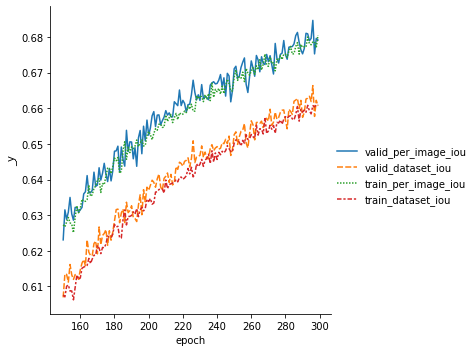

In [17]:
metrics = pd.read_csv(f"logs-swinnet/default/version_0/metrics.csv")
#drop test metrics because they are not available
# metrics = metrics.drop(columns=["test_per_image_iou", "test_dataset_iou"])
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail())
sns.relplot(data=metrics, kind="line")

## Validation and test metrics

In [20]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

[{'valid_dataset_iou': 0.6899800300598145,
  'valid_per_image_iou': 0.7067487835884094}]


In [21]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.6829068660736084,
  'test_per_image_iou': 0.7017832398414612}]


# Result visualization

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
assert 1==0, ""

# Result visualization (demo cats and dogs)

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()